# Karam Haddad Multimodal Digit Classification
# Data Preprocessing
Here, I will import all the libraries in this cell, and then load the data given from Kaggle to train and test

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd

#now load the datasets
x_train_wr = np.load('x_train_wr.npy')  #training images
x_train_sp = np.load('x_train_sp.npy')  #training audio
y_train = np.genfromtxt('y_train.csv', delimiter=',', skip_header=1)[:, 1].astype(int)  #labels converted to integers
x_test_wr = np.load('x_test_wr.npy')  #test images
x_test_sp = np.load('x_test_sp.npy')  #test spoken audio

/var/folders/vs/wqdqt6kd3gggpfgy7v7mdm340000gn/T/ipykernel_20875/992395787.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data Visualization
Print shape, type to understand how data looks and how to work with it. I also plot image and audio example to see what I'm working with

In [18]:
print("training images shape:", x_train_wr.shape)
print("train audio shapes:", x_train_sp.shape)
print("training labels shape:", y_train.shape)
print("test imgages shape", x_test_wr.shape)
print("test audio shape:", x_test_sp.shape)

#now data type
print("\ndata types:", x_train_wr.dtype, x_train_sp.dtype, y_train.dtype, x_test_wr.dtype, x_test_sp.dtype)

training images shape: (60000, 784)
train audio shapes: (60000, 507)
training labels shape: (60000,)
test imgages shape (10000, 28, 28)
test audio shape: (10000, 507)

data types: float64 float64 int64 float64 float64


After looking at the shapes, I can tell that data consists of 60k training and 10k test samples. Each image is (28x28=784) and 507 length for audio file. Knowing the data type is useful to debug any errors that may arise.

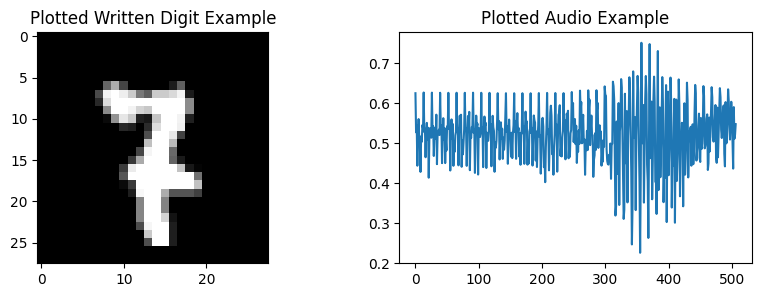

In [19]:
#plot image and audio example
fig, ax = plt.subplots(1, 2, figsize=(10, 3)) #layout and size
ax[0].imshow(x_train_wr[22].reshape(28, 28), cmap='gray') #I plotted random index out of the data, gray to remove colors
ax[0].set_title('Plotted Written Digit Example')
ax[1].plot(x_train_sp[12])
ax[1].set_title('Plotted Audio Example')
plt.show()

The plots give us a better idea of the data being worked with.

# Prepare Data
Repurpose dataset class from previous project to handle images and add audio

In [20]:
class DigitDataset(Dataset):
    def __init__(self, images, audios, labels=None, transform=None, audio_transform=None):
        #images and audios are numpy arrays
        self.images = images
        self.audios = audios
        self.labels = labels
        self.transform = transform
        self.audio_transform = audio_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if image.ndim == 1:
            image = image.reshape(28, 28) #fix if flattened

        audio = self.audios[idx] 

        if self.transform:
            image = self.transform(image)
        
        audio = torch.tensor(audio, dtype=torch.float32) #convert audio to tensor float32

        if self.labels is not None:
            #if training...
            label = torch.tensor(int(self.labels[idx]), dtype=torch.long) #convert label to int 
            #^TRYING TO FIX ERROR TYPE
            return image, audio, label #return image, audio, and label

        return image, audio
    
image_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # min max normalization... Helps with training speed
audio_transform = transforms.ToTensor() #convert audio to tensor

#splitting data & loaders...
x_train_wr, x_val_wr, x_train_sp, x_val_sp, y_train, y_val = train_test_split(x_train_wr, x_train_sp, y_train, test_size=0.2, random_state=123)

train_dataset = DigitDataset(x_train_wr, x_train_sp, y_train, transform=image_transform, audio_transform=audio_transform)
val_dataset = DigitDataset(x_val_wr, x_val_sp, y_val, transform=image_transform, audio_transform=audio_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Models definitions
ImageCNN, Audio, and Combine.

In [21]:
class ImageCNN(nn.Module):
    def __init__(self):
        super(ImageCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1) #first conv layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) #second
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) #third
        self.fc1 = nn.Linear(64 * 3 * 3, 128) 
        self.fc2 = nn.Linear(128, 10) #2 FC layers.

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class AudioNN(nn.Module):
    def __init__(self):
        super(AudioNN, self).__init__()
        self.fc1 = nn.Linear(507, 256) #first
        self.fc2 = nn.Linear(256, 128) #second 
        self.fc3 = nn.Linear(128, 10) #third layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class CombinedModel(nn.Module):
    def __init__(self, image_model, audio_model):
        super(CombinedModel, self).__init__()
        self.image_model = image_model
        self.audio_model = audio_model
        self.fc1 = nn.Linear(20, 50) #first 
        self.fc2 = nn.Linear(50, 10) #second size 10 dimension

    def forward(self, image, audio):
        image_features = self.image_model(image)
        audio_features = self.audio_model(audio)
        combined_features = torch.cat((image_features, audio_features), dim=1)
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_model = ImageCNN().to(device)
audio_model = AudioNN().to(device)
combined_model = CombinedModel(image_model, audio_model).to(device)

#Optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

# Training & evaluation


In [25]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs=10, device='cpu'):
    model.to(device) #model in device
    best_acc = 0.0
    for epoch in range(epochs):
        #training through n=epochs
        model.train()  #
        running_loss = 0.0
        for images, audios, labels in train_loader:
            images = images.to(device).float()
            audios = audios.to(device).float()
            labels = labels.to(device).long()

            optimizer.zero_grad() #zero the parameter gradients
            outputs = model(images, audios)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        acc = evaluate(model, val_loader, device) #get the accuracy 
        print(f"Epoch {epoch+1}, Epoch Loss: {epoch_loss} | WITH validation acc: {acc:.2f}%")
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    print(f'Best validation acc: {best_acc:.2f}%')

def evaluate(model, val_loader, device):
    model.eval() #let model know evaluating
    correct = 0 #predictions
    total = 0
    with torch.no_grad():
        for images, audios, labels in val_loader:
            images = images.to(device).float() #convert to float
            audios = audios.to(device).float()  
            labels = labels.to(device).long()
            outputs = model(images, audios)
            t, predicted = torch.max(outputs.data, 1) #t not used
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

#finally, train
train(combined_model, train_loader, val_loader, optimizer, criterion, epochs=10, device=device) 


Epoch 1, Epoch Loss: 0.010164968099406072 | WITH validation acc: 98.86%
Epoch 2, Epoch Loss: 0.004888739857968213 | WITH validation acc: 98.79%
Epoch 3, Epoch Loss: 0.006751482150131816 | WITH validation acc: 98.96%
Epoch 4, Epoch Loss: 0.007506672168012718 | WITH validation acc: 98.92%
Epoch 5, Epoch Loss: 0.005221612660543125 | WITH validation acc: 98.64%
Epoch 6, Epoch Loss: 0.006373952820986858 | WITH validation acc: 99.03%
Epoch 7, Epoch Loss: 0.003167592377027281 | WITH validation acc: 98.88%
Epoch 8, Epoch Loss: 0.007302388585541962 | WITH validation acc: 99.08%
Epoch 9, Epoch Loss: 0.0049884212789458315 | WITH validation acc: 99.00%
Epoch 10, Epoch Loss: 0.00726825965917385 | WITH validation acc: 98.91%
Best validation acc: 99.08%


After fixing all errors, models shows high accuracy with the maximum being 99.08% which is really good. Loss seems to generally decrease each epoch which is a good sign.


# Model inference
With the trained model, now it's time to make the predictions and save it to a csv

In [28]:
def predict(model, data_loader, device):
    #this time make a predict func.
    model.eval() #tell model we are evaluating
    predictions = []
    with torch.no_grad():
        for images, audios in data_loader:
            images = images.to(device).float()
            audios = audios.to(device).float()
            outputs = model(images, audios)
            x, predicted = torch.max(outputs.data, 1) #x not needed
            predictions.extend(predicted.cpu().numpy()) #add to predictions
    return predictions

x_test_wr = np.load('x_test_wr.npy') #load test data WRITTEN
x_test_sp = np.load('x_test_sp.npy') #SPOKEN

test_dataset = DigitDataset(x_test_wr, x_test_sp, transform=image_transform, audio_transform=audio_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) #no shuffling test data

predictions = predict(combined_model, test_loader, device) #from predict func.

#THE CSV MAGIC
submission_df = pd.DataFrame(data={'row_id': np.arange(len(predictions)), 'label': predictions})
submission_df.to_csv('preds.csv', index=False)

# Further analysis
extract features from trained model, did dimensionality reduction using TSNE, clustering with k=10, and plot data clusters

/Users/karamhaddad/Library/Python/3.9/lib/python/site-packages/threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


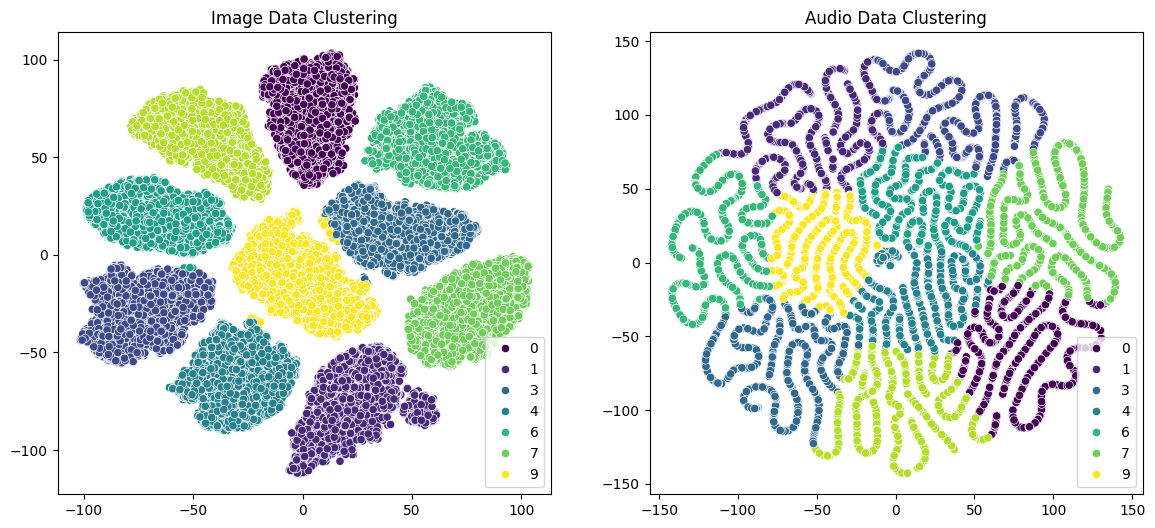

In [29]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns

def extract_features(model, data_loader, device):
    #extract features and labels from dataset
    model.eval() #tell model we are evaluating
    features = []
    labels = []
    with torch.no_grad():
        for images, audios, label in data_loader:
            images = images.to(device).float() #send images to device
            audios = audios.to(device).float() 

            image_features = model.image_model(images) #Get image features from image podel
            audio_features = model.audio_model(audios) #audio features from audio model

            features.append((image_features.cpu().numpy(), audio_features.cpu().numpy()))
            labels.extend(label.numpy())
    return features, labels

features, labels = extract_features(combined_model, train_loader, device)

#After extracting features, dimensionalitty reduction using TSNE
image_features = np.vstack([f[0] for f in features])
audio_features = np.vstack([f[1] for f in features])
tsne_image = TSNE(n_components=2).fit_transform(image_features) #reduce features to 2D to plot
tsne_audio = TSNE(n_components=2).fit_transform(audio_features)

#clustering using KMeans with k=10
kmeans_image = KMeans(n_clusters=10).fit(tsne_image)
kmeans_audio = KMeans(n_clusters=10).fit(tsne_audio)

#visualization
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_image[:, 0], y=tsne_image[:, 1], hue=kmeans_image.labels_, palette='viridis') #palette for color distinction
plt.title('Image')
plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_audio[:, 0], y=tsne_audio[:, 1], hue=kmeans_audio.labels_, palette='viridis')
plt.title('Audio')
plt.show()


# After inspecting plots...

    - image clusters look to be more clearly defined which means that the image model does the job well by highlighting features for each digit


    - audio clusters seem to overlap which means that audio data might be harder to predict and has less distinctive features when compared to images. This could be due to many factors: audio noise, different accents, the need for better model tuning, etc.